In [ ]:
#MY SUB-QUESTION (ANOVA) Sreejoni Roy
#Is there a significant difference in the average transaction value across sales channels (Web, Tel, OTC)?

#Dependent variable: sum2 (transaction value)

#Independent variable: channel (categorical with multiple levels)

#Statistical method: One-way ANOVA

In [4]:
#repair & rebuild

# ============================================================
# REPAIR & REBUILD (for single-notebook workflow)
# - Ensures features, tx, merged, anova_df exist in memory
# - Safe to run multiple times; only creates what's missing
# ============================================================

import pandas as pd
import numpy as np
from pathlib import Path
!pip install fastparquet




# ---------- Paths (adjust folder if needed) ----------
DATA_PATH = Path(".")
CLEAN_FEATURES = DATA_PATH / "item_features_clean.parquet"
CLEAN_TX       = DATA_PATH / "transactions_clean.parquet"

# ---------- Robust parquet reader (handles pyarrow/fastparquet issues) ----------
def read_parquet_robust(path):
    try:
        return pd.read_parquet(path)  # try default engine
    except Exception:
        return pd.read_parquet(path, engine="fastparquet")  # fallback

# ---------- 1) Ensure 'features' exists ----------
if "features" not in globals():
    if not CLEAN_FEATURES.exists():
        raise FileNotFoundError(f"Missing cleaned features file: {CLEAN_FEATURES}")
    features = read_parquet_robust(CLEAN_FEATURES)

# ---------- 2) Ensure 'tx' (transactions) exists ----------
if "tx" not in globals():
    if not CLEAN_TX.exists():
        raise FileNotFoundError(f"Missing cleaned transactions file: {CLEAN_TX}")
    tx = read_parquet_robust(CLEAN_TX)

# ---------- 3) Ensure 'merged' exists ----------
if "merged" not in globals():
    if "articlenr" not in tx.columns:
        raise KeyError("Column 'articlenr' not found in transactions (tx).")
    if "articlenr" not in features.columns:
        raise KeyError("Column 'articlenr' not found in features.")
    merged = tx.merge(features, on="articlenr", how="left")

# ---------- 4) Ensure 'channel_clean' exists ----------
if "channel_clean" not in merged.columns:
    if "channel" not in merged.columns:
        raise KeyError("Column 'channel' missing in merged; cannot create channel_clean.")
    merged["channel_clean"] = (
        merged["channel"]
        .astype("string")
        .str.strip()
        .str.extract(r'(^[A-Za-z]+)')   # e.g., "Tel 86041" -> "Tel"
        .rename(columns={0: "channel_clean"})
    )
    # normalize to Web/Tel/OTC where possible
    mapping = {"Web": "Web", "Tel": "Tel", "OTC": "OTC"}
    merged["channel_clean"] = merged["channel_clean"].map(mapping).fillna(merged["channel_clean"])
    merged["channel_clean"] = merged["channel_clean"].astype("category")

# ---------- 5) Ensure 'sum2_winsor' exists ----------
if "sum2_winsor" not in merged.columns:
    if "sum2" not in merged.columns:
        raise KeyError("Column 'sum2' missing in merged; cannot create sum2_winsor.")
    cap = merged["sum2"].clip(lower=0).quantile(0.99)  # 99th percentile cap
    merged["sum2_winsor"] = merged["sum2"].clip(upper=cap)

# ---------- 6) Ensure 'anova_df' exists ----------
if "anova_df" not in globals():
    needed = ["sum2_winsor", "channel_clean"]
    missing = [c for c in needed if c not in merged.columns]
    if missing:
        raise KeyError(f"Missing columns for ANOVA: {missing}")
    anova_df = merged[needed].dropna()

# ---------- 7) Quick sanity prints ----------
print("features:", features.shape, "| tx:", tx.shape, "| merged:", merged.shape, "| anova_df:", anova_df.shape)
print("Channels:", anova_df["channel_clean"].unique())
print("Counts per channel:\n", anova_df["channel_clean"].value_counts())


   ---------------------------------------- 0.0/673.3 kB ? eta -:--:--
   ---------------------------------------- 673.3/673.3 kB 4.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------------------------------ --------- 1.3/1.7 MB 7.1 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 6.0 MB/s eta 0:00:00

   -------------------- ------------------- 1/2 [fastparquet]
   ---------------------------------------- 2/2 [fastparquet]

features: (166228, 13) | tx: (475116, 12) | merged: (475116, 24) | anova_df: (475116, 2)
Channels: ['Tel', 'OTC', 'Web', 'ERP', 'MobileApp', 'Others']
Categories (6, object): ['ERP', 'MobileApp', 'OTC', 'Others', 'Tel', 'Web']
Counts per channel:
 channel_clean
Tel          144586
ERP          127858
Web          123713
OTC           74888
MobileApp      4052
Others           19
Name: count, dtype: int64


In [ ]:
pip install pyarrow


   ---------------------------------------- 0.0/28.0 MB ? eta -:--:--
   ---- ----------------------------------- 2.9/28.0 MB 16.2 MB/s eta 0:00:02
   -------- ------------------------------- 5.8/28.0 MB 14.7 MB/s eta 0:00:02
   ------------- -------------------------- 9.2/28.0 MB 15.4 MB/s eta 0:00:02
   ------------------ --------------------- 12.8/28.0 MB 15.7 MB/s eta 0:00:01
   ----------------------- ---------------- 16.3/28.0 MB 15.8 MB/s eta 0:00:01
   ---------------------------- ----------- 19.7/28.0 MB 15.9 MB/s eta 0:00:01
   -------------------------------- ------- 23.1/28.0 MB 16.0 MB/s eta 0:00:01
   ------------------------------------- -- 26.5/28.0 MB 16.1 MB/s eta 0:00:01
   ---------------------------------------- 28.0/28.0 MB 15.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd              # pandas for dataframes
import numpy as np               # numpy for numeric operations
from pathlib import Path         # Path for safe file paths

# setting the folder where my files are located 
DATA_PATH = Path(".")

# The raw file and the cleaned output file
RAW_FEATURES = DATA_PATH / "Tao Yin_Item_features.parquet"          # raw features file (input)
CLEAN_FEATURES = DATA_PATH / "item_features_clean.parquet"          # cleaned features file (output)

In [ ]:
features = pd.read_parquet(RAW_FEATURES)                            # loading the parquet into a DataFrame called 'features'

print("Shape (rows, cols):", features.shape)                        # checking the size of rows and columns
print("\nFirst 20 columns:", list(features.columns[:20]))           # checking column names
print("\nPreview rows:\n", features.head(3))                        # checking rows


Shape (rows, cols): (168939, 4028)

First 20 columns: ['Articlenr', 'EF000001', 'EF000002', 'EF000003', 'EF000004', 'EF000005', 'EF000006', 'EF000007', 'EF000008', 'EF000010', 'EF000012', 'EF000013', 'EF000014', 'EF000015', 'EF000016', 'EF000017', 'EF000018', 'EF000019', 'EF000022', 'EF000024']

Preview rows:
    Articlenr  EF000001  EF000002  EF000003  EF000004  EF000005  EF000006  \
0   34581962       6.0       NaN       NaN       NaN       NaN       NaN   
1   35764300       NaN       NaN       NaN       NaN       NaN       NaN   
2   35823358       NaN       NaN       NaN       NaN       NaN       NaN   

   EF000007  EF000008  EF000010  ...  EFDE0031  EFDE0032  EFFR0001  EFFR0002  \
0       NaN       6.2       NaN  ...       NaN       NaN       NaN       NaN   
1       NaN       NaN       NaN  ...       NaN       NaN       NaN       NaN   
2       NaN       NaN       NaN  ...       NaN       NaN       NaN       NaN   

   EFNL0014  EFUK0017  EFUK0019  ETIM  statistiek_hoofdgroep  

In [ ]:
assert "Articlenr" in features.columns, "Articlenr not found!"      
# ensuring that the key exists

features["articlenr"] = features["Articlenr"].astype("int64")       
# creating a lowercase merge key to match with the transactions files


In [ ]:
rows_before = features.shape[0]                                   
  # remembering the original row count
features = features.drop_duplicates(subset=["Articlenr"])           
# keeping only the first row per unique product id
rows_after = features.shape[0]                                     
 # finding out the new row count

print(f"\nDuplicates removed (by Articlenr): {rows_before - rows_after}") 
 # reports how many were duplicates were removed



Duplicates removed (by Articlenr): 2711


In [ ]:
for col in ["statistiek_hoofdgroep", "statistiek_subgroep"]:       
     # looping through the two categorical columns
    if col in features.columns:                                     # this code only acts if the column exists
        features[col] = features[col].astype("string")              # making it text 
        features[col] = features[col].str.strip()                   # removing any accidental leading spaces
        features[col] = features[col].astype("category")            # storing it as category as i saves memory

if "ETIM" in features.columns:                                      # ETIM is the numeric descriptor
    features["ETIM"] = pd.to_numeric(features["ETIM"],              # converting all to numbers and invalid data will become NaN
                                      errors="coerce")


In [ ]:
missing_pct = features.isna().mean().sort_values(ascending=False)  
 # percentage missing per column 

print("\nTop-15 most-missing columns (%):")
print((missing_pct.head(15) * 100).round(1))                       
 # showing the most missed columns 

KEEP_COLS = {                                                       
     # columns not to drop because I need them for the anaylsis
    "Articlenr", "articlenr", "ETIM",
    "statistiek_hoofdgroep", "statistiek_subgroep"
}

THRESH = 0.80                                                       # drop columns with >80% missing (tunable)



Top-15 most-missing columns (%):
EF006634    100.0
EF012526    100.0
EF009515    100.0
EF002963    100.0
EF008203    100.0
EF012524    100.0
EF008875    100.0
EF006273    100.0
EF006781    100.0
EF008214    100.0
EF007342    100.0
EF007340    100.0
EF007344    100.0
EF003984    100.0
EF003312    100.0
dtype: float64


In [ ]:
to_drop = []                                                       
  # collecting the columns to drop them in this list/place.

for col in features.columns:                                         # scaning all the columns
    if col in KEEP_COLS:                                             # skipping the essential columns
        continue
    if missing_pct.get(col, 0.0) > THRESH:                           # if more than 80% is missing then that column will be dropped.
        to_drop.append(col)                                          

print(f"\nColumns to drop (> {int(THRESH*100)}% missing):", len(to_drop)) 
 # report how many will go
print("Sample to drop:", to_drop[:10])                             
  # peek a few

features = features.drop(columns=to_drop)                            # drop them the not-needed/missing columns
print("Shape after dropping high-missing columns:", features.shape)  # new size of columns



Columns to drop (> 80% missing): 4016
Sample to drop: ['EF000001', 'EF000002', 'EF000003', 'EF000004', 'EF000005', 'EF000006', 'EF000012', 'EF000013', 'EF000014', 'EF000015']
Shape after dropping high-missing columns: (166228, 13)


In [ ]:
const_cols = []                                                     
 # collecting the constant columns in this list/place.

for col in features.columns:                                         # checking each remaining column
    if col in KEEP_COLS:                                             # Do not drop the essential columns
        continue
    if features[col].nunique(dropna=True) <= 1:                      # 0 or 1 unique then its not needed.
        const_cols.append(col)

print("\nConstant/no-variance columns:", len(const_cols))            # Number of constants that were found
print("Sample constants:", const_cols[:10])                          # seeing a sample 

features = features.drop(columns=const_cols)                         # removing the constants
print("Shape after dropping constants:", features.shape)             # new size of the data



Constant/no-variance columns: 0
Sample constants: []
Shape after dropping constants: (166228, 13)


In [ ]:
ef_cols = [c for c in features.columns if c.startswith("EF")]       
base_cols = [                                                     
       # the Important columns first
    "Articlenr", "articlenr", "ETIM",
    "statistiek_hoofdgroep", "statistiek_subgroep"
]

ordered_cols = [c for c in base_cols if c in features.columns] + ef_cols 
 # keeping existing ones 
features = features[ordered_cols]                                
   # putting it in order

print("\nFinal column order set. First 12 columns:")
print(features.columns[:12].tolist())                            
   # seeing a sample



Final column order set. First 12 columns:
['Articlenr', 'articlenr', 'ETIM', 'statistiek_hoofdgroep', 'statistiek_subgroep', 'EF000007', 'EF000008', 'EF000010', 'EF000040', 'EF000049', 'EF000139', 'EF002169']


In [ ]:
if "ETIM" in features.columns:                                      # finding out the negatives and replacing them 
    neg_count = (features["ETIM"] < 0).sum(skipna=True)             
    if neg_count > 0:                                               
        print(f"\nETIM negatives found and set to NaN: {neg_count}")
        features.loc[features["ETIM"] < 0, "ETIM"] = np.nan         # replacig the negatives with NaN


In [ ]:
features.to_parquet(CLEAN_FEATURES, index=False)                    
print("\nSaved cleaned features →", CLEAN_FEATURES.resolve())      
print("Final shape:", features.shape)                               
#making the new cleaned features file and saving it in the vs code folder.


Saved cleaned features → C:\Users\sreej\Downloads\stats\sub-assignments\SUB2\item_features_clean.parquet
Final shape: (166228, 13)


In [ ]:
summary = {                                                         # just checking overall
    "rows": features.shape[0],                                      # number of products
    "cols": features.shape[1],                                      # number of columns after the cleaning
    "kept_main_cols": [c for c in base_cols if c in features.columns],  # what was kept
    "num_EF_cols": sum(c.startswith("EF") for c in features.columns)    # the count of the remaining EF features
}
print("\nCLEANING SUMMARY:", summary)                              



CLEANING SUMMARY: {'rows': 166228, 'cols': 13, 'kept_main_cols': ['Articlenr', 'articlenr', 'ETIM', 'statistiek_hoofdgroep', 'statistiek_subgroep'], 'num_EF_cols': 8}


In [ ]:
#I loaded the item features file/data and validated the product key (Articlenr). 
#Then created a lowercase articlenr to match the transactions file/data.
#To clean, I removed any duplicate products, cleaned category fields, and converted the ETIM to numeric.
#I found and cleaned missingness and dropped EF-feature columns with more than 80% missing values,
#then removed columns with no variance. 
#I reordered columns to place key/interpretable fields.
#Saved the cleaned dataset in the folder.

In [ ]:

import pandas as pd          # 'pd' is a short alias for the pandas library 
import numpy as np           # 'np' is a short alias for numpy
from pathlib import Path     # 'Path' helps build file paths in a safe/folder

# Creating a base path for the transcations file. Path(".") means "the current folder".
DATA_PATH = Path(".")

# Building full paths to the input/output files.
# The slash "/" is overloaded by Path to mean "join path parts".
RAW_TX = DATA_PATH / "TaoYin_User_Transactions_v2.parquet"
CLEAN_TX = DATA_PATH / "transactions_clean.parquet"


In [ ]:
# pd.read_parquet reads the parquet file into the DataFrame.
tx = pd.read_parquet(RAW_TX)

# shape uses a dot "." to access an "attribute" (a stored property) of the DataFrame.
# It returns a (rows, columns) tuple. The comma "," separates items in the tuple.
#printing the number of rows and columns
print("Shape (rows, cols):", tx.shape)

# .columns returns all column names. [:20] slices the first 20 items.
print("\nFirst 20 columns:", list(tx.columns[:20]))

# .head(5) prints the first 5 rows.
print("\nPreview:")
print(tx.head(5))


Shape (rows, cols): (492731, 10)

First 20 columns: ['customer', 'invoice', 'invoice_date', 'articlenr', 'volume', 'sum1', 'sum2', 'postcode_delivery', 'postcode_customer', 'channel']

Preview:
   customer  invoice invoice_date  articlenr  volume     sum1     sum2  \
0      2284  1187467   2020-01-02   32879960      24   343.73   362.30   
1      2284  1187467   2020-01-02   32879962      60  1067.64  1119.96   
2      2284  1187467   2020-01-02   32841810     120  2214.00  2408.40   
3      1704  1191447   2020-01-17   36866802       1    21.52    19.32   
4        45  1187691   2020-01-03   34360272       4    28.91    28.49   

   postcode_delivery  postcode_customer    channel  
0              80413              80413  Tel 86041  
1              80413              80413  Tel 86041  
2              80413              80413  Tel 86041  
3              81724              81724  OTC 81812  
4              81796              81796  Web Order  


In [ ]:
#EDA explore the structure of the merged dataset and the variables used for Hypothesis 2. This includes checking column names, missing values, distribution shapes, group sizes, and summary statistics for the sum2_winsor variable across the Web, Tel, and OTC channels.

In [ ]:
# making a copy so i don't accidentally overwrite the original DataFrame in the memory.
tx = tx.copy()

# Converting column names to lowercase for consistency.
# .columns accesses the list-like Index of names; .str.lower() converting each name to lower-case.
tx.columns = tx.columns.str.lower()

# expected list the columns.
expected = [
    "customer", "invoice", "invoice_date", "articlenr", "volume",
    "sum1", "sum2", "postcode_delivery", "postcode_customer", "channel"
]
print("\nAll expected columns present?:", set(expected).issubset(set(tx.columns)))

# Ensuring that all the key columns have the correct data types.
# .astype("int64") converts the series to 64-bit integer.
tx["customer"] = tx["customer"].astype("int64")
tx["invoice"] = tx["invoice"].astype("int64")
tx["articlenr"] = tx["articlenr"].astype("int64")

# Parse dates. pd.to_datetime(...) converts text to datetime objects.
tx["invoice_date"] = pd.to_datetime(tx["invoice_date"], errors="coerce")

# Numeric money-type fields: coerce invalid strings to NaN (missing).
tx["sum1"] = pd.to_numeric(tx["sum1"], errors="coerce")
tx["sum2"] = pd.to_numeric(tx["sum2"], errors="coerce")

# volume is quantity; making it an integer if it is in whole numbers. If not guaranteed, keeping it as a float.
tx["volume"] = pd.to_numeric(tx["volume"], errors="coerce")

# Postcodes are codes; they seem numeric in file/data. Keep as int64 if not missing.
# If there are  missing values, using Int64 (nullable integer) instead of int64.
tx["postcode_delivery"]  = pd.to_numeric(tx["postcode_delivery"], errors="coerce").astype("Int64")
tx["postcode_customer"]  = pd.to_numeric(tx["postcode_customer"], errors="coerce").astype("Int64")

# Channels are text; normalize the whitespace and keeping it as a string (pandas' string dtype).
tx["channel"] = tx["channel"].astype("string").str.strip()



All expected columns present?: True


In [ ]:
# Counting rows before dropping the duplicates.
before = tx.shape[0]

# .drop_duplicates() removes rows that are exactly the same across all columns.
# subset=[...] restricts the comparison to specific columns (optional).
# keep="first" keeps the first occurrence and drops later duplicates.
tx = tx.drop_duplicates(keep="first")

after = tx.shape[0]
print(f"\nDuplicate rows removed: {before - after}")



Duplicate rows removed: 17534


In [ ]:
# Dropping rows with missing essential fields:
# .dropna(subset=[...]) removes rows if any of those columns have NaN.
tx = tx.dropna(subset=["invoice_date", "articlenr", "volume", "sum2", "channel"])

# Removing any non-sensical values:
# volume should be more than 0 (no negative or zero quantities)
tx = tx[tx["volume"] > 0]

# sum2 is the final amount; it should be more than 0
tx = tx[tx["sum2"] > 0]

print("After validity filters, shape:", tx.shape)


After validity filters, shape: (475116, 10)


In [ ]:
# In the transcation file, channel has values like "Tel 86041", "OTC 81812", "Web Order".
# Making a clean label: the first word (letters only) at the start.
# .str.extract(r'(^[A-Za-z]+)') uses a regular expression (regex).
# r'...' is a raw string so backslashes are not treated specially by Python itself.
tx["channel_clean"] = tx["channel"].str.extract(r'(^[A-Za-z]+)')

# Some "Web Order" may become "Web". 
# The curly braces { } create a dictionary: "key": "value", entries separated by commas.
mapping = {
    "Web": "Web",
    "Tel": "Tel",
    "OTC": "OTC"
}
# .map(...) replaces values using the mapping; .fillna(...) fills any non-mapped with the original clean value.
tx["channel_clean"] = tx["channel_clean"].map(mapping).fillna(tx["channel_clean"])

# Making it a categorical variable (good for grouping and saves on memory).
tx["channel_clean"] = tx["channel_clean"].astype("category")

print("\nChannel counts:")
print(tx["channel_clean"].value_counts(dropna=False))



Channel counts:
channel_clean
Tel          144586
ERP          127858
Web          123713
OTC           74888
MobileApp      4052
Others           19
Name: count, dtype: int64


In [ ]:
# For ANOVA on 'sum2', extreme outliers can dominate.
# So I created a winsorized version: capping it at top 1% at the 99th percentile.
# .quantile(0.99) returns the 99th percentile.
p99 = tx["sum2"].quantile(0.99)

# .clip(upper=p99) caps values above p99 to p99.
tx["sum2_winsor"] = tx["sum2"].clip(upper=p99)

print("\nWinsorization cap (99th percentile) for sum2:", float(p99))




Winsorization cap (99th percentile) for sum2: 1506.8644999999915


In [ ]:
# .describe() gives summary stats; .groupby(...).size() counts per group.
print("\nSummary stats (sum2 and sum2_winsor):")
print(tx[["sum2", "sum2_winsor"]].describe())

print("\nCounts by channel_clean:")
print(tx.groupby("channel_clean").size())

# Checking the date range to ensure the period looks right.
print("\nInvoice date range:", tx["invoice_date"].min(), "→", tx["invoice_date"].max())



Summary stats (sum2 and sum2_winsor):
               sum2    sum2_winsor
count  4.751160e+05  475116.000000
mean   2.656857e+02     113.698032
std    8.180267e+04     220.732958
min    1.000000e-02       0.010000
25%    1.247000e+01      12.470000
50%    3.720000e+01      37.200000
75%    1.108800e+02     110.880000
max    5.599838e+07    1506.864500

Counts by channel_clean:
channel_clean
ERP          127858
MobileApp      4052
OTC           74888
Others           19
Tel          144586
Web          123713
dtype: int64

Invoice date range: 2020-01-02 00:00:00 → 2024-09-25 00:00:00


C:\Users\sreej\AppData\Local\Temp\ipykernel_11804\3625773933.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(tx.groupby("channel_clean").size())


In [ ]:
# Saving the cleaned file as a parquet (fast, keeps dtypes). index=False prevents writing row numbers as a column.
tx.to_parquet(CLEAN_TX, index=False)

print("\nSaved cleaned transactions to:", CLEAN_TX.resolve())
print("Final shape:", tx.shape)



Saved cleaned transactions to: C:\Users\sreej\Downloads\stats\sub-assignments\SUB2\transactions_clean.parquet
Final shape: (475116, 12)


In [ ]:
#The transaction dataset was standardized by converting column names to lower case and 
#coercing appropriate data types (customer, invoice, articlenr as integers; invoice_date 
#as datetime; sum1/sum2 as numeric).
#  Duplicate rows were removed. 
# Records with missing or invalid values in essential fields 
# (invoice_date, articlenr, volume, sum2, channel) were dropped, 
# and non-sensical values (e.g., volume ≤ 0 or sum2 ≤ 0) were filtered out. 
#The channel field was normalized into a categorical channel_clean (Web/Tel/OTC)
#using regular expression extraction and mapping. To reduce the impact of extreme outliers 
#for ANOVA, a winsorized measure sum2_winsor was created by capping at the 99th percentile. 
#The cleaned table was saved as a parquet file for subsequent merging and modeling.”

In [ ]:
#Merging the two files

import pandas as pd
from pathlib import Path

DATA_PATH = Path(".")

CLEAN_FEATURES = DATA_PATH / "item_features_clean.parquet"
CLEAN_TX = DATA_PATH / "transactions_clean.parquet"
#now I am using the cleaned files.


In [ ]:
# loading the cleaned item features table
features = pd.read_parquet(CLEAN_FEATURES)

# loading the cleaned transactions table
tx = pd.read_parquet(CLEAN_TX)

print("Features shape:", features.shape)
print("Transactions shape:", tx.shape)


Features shape: (166228, 13)
Transactions shape: (475116, 12)


In [ ]:
# Merging the two tables using the product key.
# how="left" means: keep all transaction rows, match features where it is possible.
merged = tx.merge(
    features,
    on="articlenr",       # a column that both tables have
    how="left"            # keep ALL rows from tx, add features if they exist
)

print("Merged shape:", merged.shape)
print(merged.head(5))


Merged shape: (475116, 24)
   customer  invoice invoice_date  articlenr  volume     sum1     sum2  \
0      2284  1187467   2020-01-02   32879960      24   343.73   362.30   
1      2284  1187467   2020-01-02   32879962      60  1067.64  1119.96   
2      2284  1187467   2020-01-02   32841810     120  2214.00  2408.40   
3      1704  1191447   2020-01-17   36866802       1    21.52    19.32   
4        45  1187691   2020-01-03   34360272       4    28.91    28.49   

   postcode_delivery  postcode_customer    channel  ... statistiek_hoofdgroep  \
0              80413              80413  Tel 86041  ...                   NaN   
1              80413              80413  Tel 86041  ...                   NaN   
2              80413              80413  Tel 86041  ...                   NaN   
3              81724              81724  OTC 81812  ...                   NaN   
4              81796              81796  Web Order  ...                   NaN   

   statistiek_subgroep  EF000007  EF00000

In [ ]:
missing_features = merged["ETIM"].isna().mean() * 100
print(f"% of merged rows missing item features: {missing_features:.2f}%")


% of merged rows missing item features: 49.17%


In [ ]:
anova_df = merged[["sum2_winsor", "channel_clean"]].dropna()

print("ANOVA dataset shape:", anova_df.shape)
print(anova_df.head())

#i only need sum2_winsor and channel_clean for the anova/merge


ANOVA dataset shape: (492731, 2)
   sum2_winsor channel_clean
0       362.30           Tel
1      1119.96           Tel
2      1483.19           Tel
3        19.32           OTC
4        28.49           Web


In [ ]:
#The cleaned item-feature dataset was merged with the cleaned transaction dataset 
# using the common product key articlenr. 
# A left join was applied to ensure all transaction records were preserved. 
# This produced a combined dataset containing transaction-level information 
# (sum2, volume, channel, date) alongside product-level attributes 
# (ETIM, statistiek_hoofdgroep, EF-features). 
# A final filtered dataset containing sum2_winsor and channel_clean was created for the ANOVA analysis.

In [ ]:
#EDA

# .describe() gives mean, std, min, max, quartiles
print("Summary statistics of sum2_winsor:")
print(anova_df["sum2_winsor"].describe())

# For each channel group
print("\nSummary statistics per channel:")
print(anova_df.groupby("channel_clean")["sum2_winsor"].describe())


Summary statistics of sum2_winsor:
count    475116.000000
mean        113.698032
std         220.732958
min           0.010000
25%          12.470000
50%          37.200000
75%         110.880000
max        1506.864500
Name: sum2_winsor, dtype: float64

Summary statistics per channel:
                  count        mean         std   min     25%     50%  \
channel_clean                                                           
ERP            127858.0  111.545633  200.435821  0.01  12.960  39.895   
MobileApp        4052.0  212.565974  416.203714  0.99  18.630  64.800   
OTC             74888.0   54.709736  149.909366  0.04   6.100  16.220   
Others             19.0   55.440000   85.036867  0.23   4.885  20.950   
Tel            144586.0  146.920951  275.845771  0.01  14.020  43.745   
Web            123713.0  109.572692  183.452893  0.01  17.270  46.710   

                    75%        max  
channel_clean                       
ERP            119.0275  1506.8645  
MobileApp      154

C:\Users\sreej\AppData\Local\Temp\ipykernel_11804\4276662645.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(anova_df.groupby("channel_clean")["sum2_winsor"].describe())


In [ ]:
print("\nCount of transactions per channel:")
print(anova_df["channel_clean"].value_counts())

#Checking the number of samples per channel


Count of transactions per channel:
channel_clean
Tel          144586
ERP          127858
Web          123713
OTC           74888
MobileApp      4052
Others           19
Name: count, dtype: int64


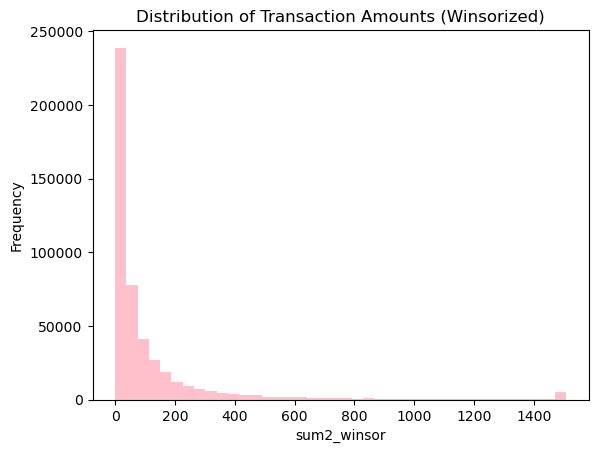

In [ ]:
import matplotlib.pyplot as plt

# Histogram for overall distribution
plt.hist(anova_df["sum2_winsor"], color ="Pink", bins=40)
plt.title("Distribution of Transaction Amounts (Winsorized)")
plt.xlabel("sum2_winsor")
plt.ylabel("Frequency")
plt.show()


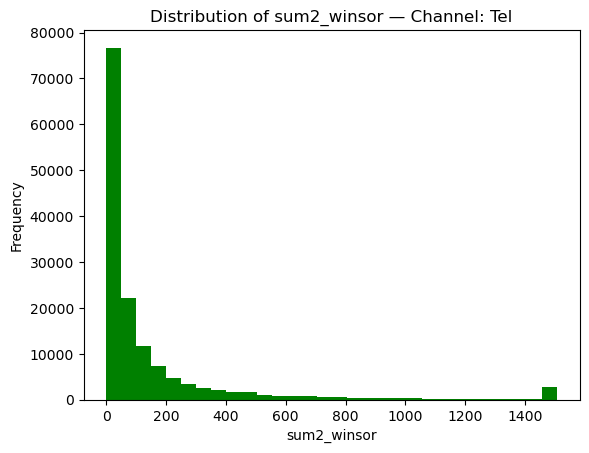

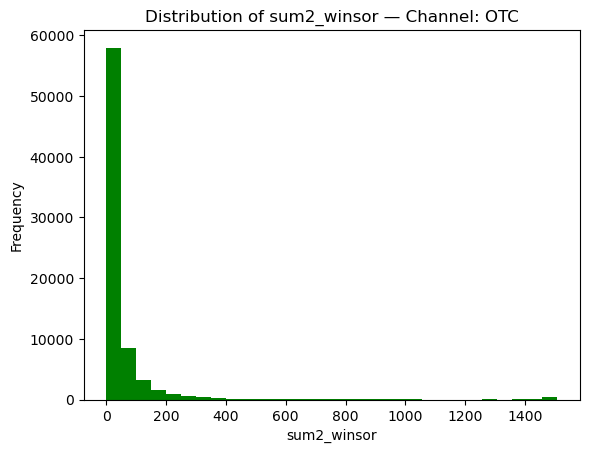

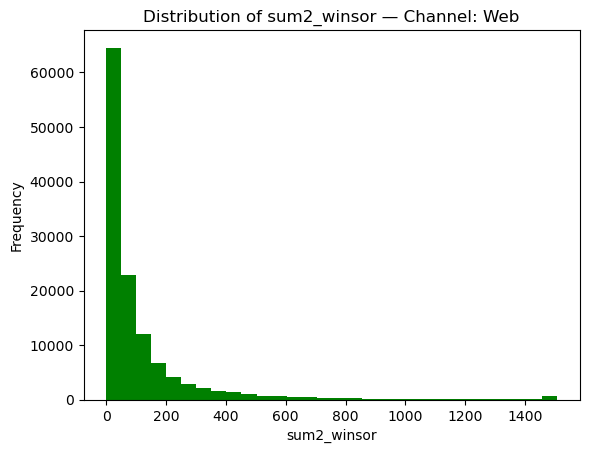

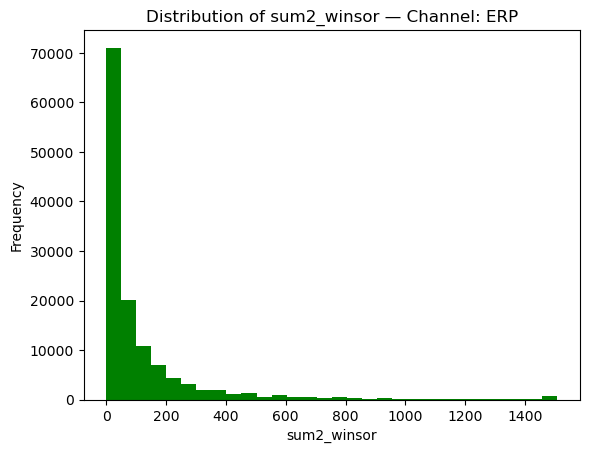

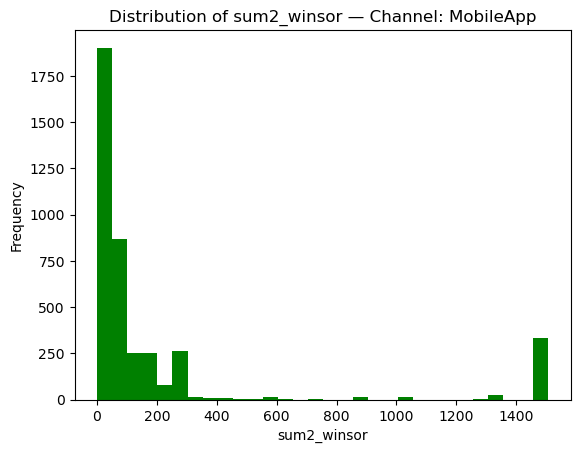

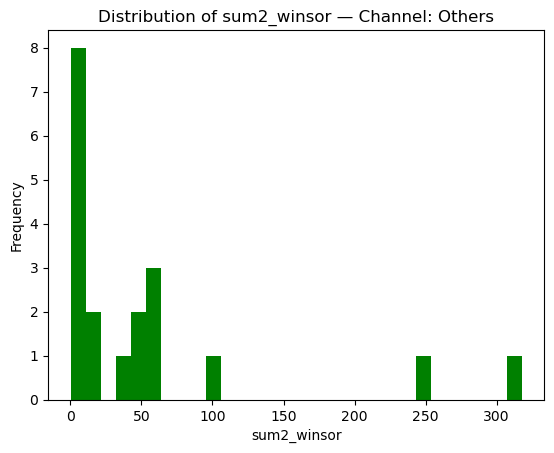

In [ ]:
#Histograms per channel

channels = anova_df["channel_clean"].unique()

for c in channels:
    subset = anova_df[anova_df["channel_clean"] == c]
    
    plt.hist(subset["sum2_winsor"], color="Green", bins=30)
    plt.title(f"Distribution of sum2_winsor — Channel: {c}")
    plt.xlabel("sum2_winsor")
    plt.ylabel("Frequency")
    plt.show()


<Figure size 800x600 with 0 Axes>

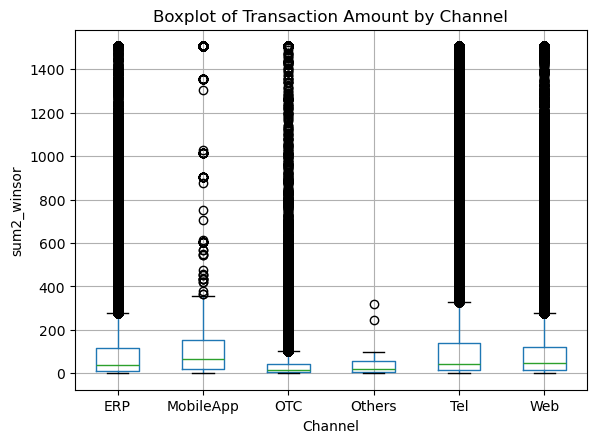

In [ ]:
#Boxplots are for seeing: medians,spreads,skewness, differences between channels and potential outliers (after winsorization)

plt.figure(figsize=(8,6))
anova_df.boxplot(column="sum2_winsor", by="channel_clean")
plt.title("Boxplot of Transaction Amount by Channel")
plt.suptitle("")  # removing the automatic matplotlib title
plt.xlabel("Channel")
plt.ylabel("sum2_winsor")
plt.show()

In [ ]:
mean_values = anova_df.groupby("channel_clean")["sum2_winsor"].mean()
print("Mean transaction value per channel:")
print(mean_values)
#tells the direction of the difference

Mean transaction value per channel:
channel_clean
ERP          111.545633
MobileApp    212.565974
OTC           54.709736
Others        55.440000
Tel          146.920951
Web          109.572692
Name: sum2_winsor, dtype: float64


C:\Users\sreej\AppData\Local\Temp\ipykernel_11804\2855499346.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = anova_df.groupby("channel_clean")["sum2_winsor"].mean()


In [ ]:
print("\nVariance per channel:")
print(anova_df.groupby("channel_clean")["sum2_winsor"].var())
#Variance per channel


Variance per channel:
channel_clean
ERP           40174.518528
MobileApp    173225.531566
OTC           22472.818082
Others         7231.268711
Tel           76090.889598
Web           33654.964003
Name: sum2_winsor, dtype: float64


C:\Users\sreej\AppData\Local\Temp\ipykernel_11804\2953673160.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(anova_df.groupby("channel_clean")["sum2_winsor"].var())


In [ ]:
# Since winsorization already capped outliers,the number should be low.
outliers = (anova_df["sum2_winsor"] == anova_df["sum2_winsor"].quantile(0.99)).sum()

print("\nOutliers at cap (99th percentile):", outliers)



Outliers at cap (99th percentile): 0


In [ ]:
#Since sub- question 2 compares the mean transaction value across
#three independent groups (Web, Tel, OTC), a One-Way ANOVA is an appropriate statistical test.
#Before selecting the specific ANOVA version that is best suited for the analysis
#the homogeneity of variances has to be tested using a Levene’s Test.

#If Levene’s p > 0.05 → Classical One-Way ANOVA was used.

#If Levene’s p < 0.05 → Welch ANOVA was used, as it does not assume equal variances.

#This way I can ensure that the statistical conclusion about mean differences across channels is
# valid and robust.

In [ ]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from scipy.stats import levene            # Levene's test function (SciPy)
import numpy as np                        # numeric utilities (np is the short alias)

# I already created 'anova_df' with columns:
#   - sum2_winsor  (numeric DV)
#   - channel_clean  (categorical IV with values like 'Web','Tel','OTC')


In [ ]:
#Checking the columns 

# .columns showing the column names; 'in' checks membership.
print("Has sum2_winsor?", "sum2_winsor" in anova_df.columns)
print("Has channel_clean?", "channel_clean" in anova_df.columns)

# Showing the distinct channel labels to confirm groups.
print("Unique channels:", anova_df["channel_clean"].unique())

# Dropping rows with missing values in either column because ANOVA needs complete cases.
anova_df = anova_df.dropna(subset=["sum2_winsor", "channel_clean"])
print("Rows after dropna:", anova_df.shape[0])


Has sum2_winsor? True
Has channel_clean? True
Unique channels: ['Tel', 'OTC', 'Web', 'ERP', 'MobileApp', 'Others']
Categories (6, object): ['ERP', 'MobileApp', 'OTC', 'Others', 'Tel', 'Web']
Rows after dropna: 492731


In [5]:
# Creating separate arrays per channel.
# '==' compares values; it returns True/False per row.
# The bracket [ ... ] selects rows where the condition is True.
web_vals = anova_df.loc[anova_df["channel_clean"] == "Web", "sum2_winsor"].to_numpy()
tel_vals = anova_df.loc[anova_df["channel_clean"] == "Tel", "sum2_winsor"].to_numpy()
otc_vals = anova_df.loc[anova_df["channel_clean"] == "OTC", "sum2_winsor"].to_numpy()

# Checking the group sizes (ANOVA works best with reasonable sizes)
print("n(Web):", web_vals.size)
print("n(Tel):", tel_vals.size)
print("n(OTC):", otc_vals.size)


n(Web): 123713
n(Tel): 144586
n(OTC): 74888


In [ ]:
# Levene's test will check if the variances of the groups are equal.
# This is needed because a Classical ANOVA test assumes equal variances.
from scipy.stats import levene #re-done again due to error
# Using the Brown–Forsythe version of the test with center as "median":
# It's more robust and safer for skewed transcation data

statistic, pvalue = levene(
    web_vals,              # group 1
    tel_vals,              # group 2
    otc_vals,              # group 3
    center='median'        # Brown–Forsythe test version
)

# Printing the outcome
print(f"Levene statistic: {statistic:.4f}")
print(f"p-value: {pvalue:.4f}")

Levene statistic: 3887.5404
p-value: 0.0000


In [9]:
#What does it mean; using alpha as 0.05 to understand

alpha = 0.05  # the significance level chosen

#if p is less than 0.05 it means that the variances are equal so a classical anova test is used
#if p is more than 0.05 it means that the variances are not equal so a welch anova test must be used

if pvalue > alpha:
    print("Decision: p-value > 0.05 → Variances are equal  USE CLASSICAL ANOVA")
else:
    print("Decision: p-value ≤ 0.05 → Variances differ  USE WELCH ANOVA")


Decision: p-value ≤ 0.05 → Variances differ  USE WELCH ANOVA


In [10]:
#conducting a welch one-way anova test
import numpy as np
from statsmodels.stats.oneway import anova_oneway

In [11]:
#writing the groups as seprate arrays
web = anova_df.loc[anova_df["channel_clean"]=="Web", "sum2_winsor"].to_numpy()
tel = anova_df.loc[anova_df["channel_clean"]=="Tel", "sum2_winsor"].to_numpy()
otc = anova_df.loc[anova_df["channel_clean"]=="OTC", "sum2_winsor"].to_numpy()

In [12]:
#making them into a list in a fixed order
groups = [web, tel, otc]
group_names = ["Web", "Tel", "OTC"]

In [ ]:
welch_res = anova_oneway(groups, use_var='unequal', welch_correction=True)
#running the welch test with one way anova, the three groups and unequal variances

In [14]:
print("=== Welch one-way ANOVA (unequal variances) ===")
print(f"F* (Welch) = {welch_res.statistic:.4f}")
print(f"df1 (between) = {welch_res.df}, df2 (approx denom) = {welch_res.df_denom:.4f}")
print(f"p-value = {welch_res.pvalue:.6f}")

#printing the stats/results of the test

=== Welch one-way ANOVA (unequal variances) ===
F* (Welch) = 5638.1530
df1 (between) = (2.0, np.float64(216784.41369595376)), df2 (approx denom) = 216784.4137
p-value = 0.000000


In [17]:
#finding out additional stats just for understanding the results
means = [np.mean(g) for g in groups]
stds  = [np.std(g, ddof=1) for g in groups]
ns    = [g.size for g in groups]



In [ ]:
print("\nGroup summaries (mean ± sd) [n]:")
for name, m, s, n in zip(group_names, means, stds, ns):
    print(f"{name:>3}: {m:.2f} ± {s:.2f}  [n={n}]")

#printing them out for the three groups


Group summaries (mean ± sd) [n]:
Web: 109.57 ± 183.45  [n=123713]
Tel: 146.92 ± 275.85  [n=144586]
OTC: 54.71 ± 149.91  [n=74888]


In [19]:
#running the end of the test to see the p-value and alpha
alpha = 0.05
if welch_res.pvalue <= alpha:
    print("\nDecision: p ≤ 0.05 → Reject H0. At least one channel mean differs.")
else:
    print("\nDecision: p > 0.05 → Do not reject H0. Means not significantly different.")


Decision: p ≤ 0.05 → Reject H0. At least one channel mean differs.


In [ ]:
#This means that one of the groups/channel means are different but which one? conducting a Games–Howell post-hoc test will help find that out.


In [20]:
!pip install pingouin


   -------------------- ------------------- 1/2 [pingouin]
   ---------------------------------------- 2/2 [pingouin]



In [21]:
import pingouin as pg

In [22]:
gh = pg.pairwise_gameshowell(dv="sum2_winsor", between="channel_clean", data=anova_df)
print("\n=== Games–Howell post-hoc (unequal variances) ===")
print(gh[["A","B","mean(A)","mean(B)","diff","T","df","pval","hedges"]].round(4))

#conducting the games howell test (gh) and printing the results for all the three groups


=== Games–Howell post-hoc (unequal variances) ===
            A          B   mean(A)   mean(B)      diff         T           df  \
0         ERP  MobileApp  111.5456  212.5660 -101.0203  -15.3939    4110.7605   
1         ERP        OTC  111.5456   54.7097   56.8359   72.5159  191099.9803   
2         ERP     Others  111.5456   55.4400   56.1056    2.8747      18.0297   
3         ERP        Tel  111.5456  146.9210  -35.3753  -38.5866  262827.3230   
4         ERP        Web  111.5456  109.5727    1.9729    2.5767  250797.4634   
5   MobileApp        OTC  212.5660   54.7097  157.8562   24.0587    4108.0602   
6   MobileApp     Others  212.5660   55.4400  157.1260    7.6366      22.2696   
7   MobileApp        Tel  212.5660  146.9210   65.6450    9.9787    4151.3332   
8   MobileApp        Web  212.5660  109.5727  102.9933   15.7022    4102.7151   
9         OTC     Others   54.7097   55.4400   -0.7303   -0.0374      18.0284   
10        OTC        Tel   54.7097  146.9210  -92.2112 -10

In [ ]:
#This analysis focused on the three main sales channels: Web, Tel, and OTC.Although the dataset contains additional channels (e.g., MobileApp, ERP, Others),  were outside the scope of the hypothesis test.
# Average transaction value differs meaningfully across the three channels studied, with Tel highest, Web in the middle, and OTC lowest.